In [283]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
import sklearn.metrics
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFE
from datetime import datetime
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

## Load and describe the data

## Dataset

The raw dataset includes all weekly performance information for all LOCs(18,833 unique loan ids) that has originated between 2013-09-18 and 2018-05-02: 1,236,623 observations in total.

## Data Dictionary

### Target Variable
1. write_off_flag -  Loan default status.  The status is a binary variable, where 1 means "Yes" and 0 means "No".

### Input Variables
1. loan_id - The unique identifier for each LOC account.    
2. as_of_date - The effective date that reflects what each metric on that table was as of the specific date in    
   question.
3. total_outstanding_principal - The Outstanding Prinicipal owed on the LOC account.
4. last_draw_date - The date of the most recent draw made that is still in a cleared state.
5. dpd_calendar - The count of days past due in "calendar days".
6. last_cleared_payment_date - The date of the most recent regular and one-time payment made that is still in a 
   cleared state.
7. credit_limit - The credit limit of the LOC account on the as_of_date.
8. lsp_wo_new_principal - The sum of the amounts of principal of both write off and additional write off transactions.
9. lsp_wo_new_interest - The sum of the amounts of interest of both write off and additional write off transactions.
10. past_due_principal - The Prinicipal that is past due on the LOC account (this is a subset of the Outstanding    
    Principal).
11. past_due_interest - The Interest that is past due on the LOC account (this is a subset of the Outstanding 
    Interest).
12. write_off_date - The date the LOC account was written off.
13. current_utilization_pct - The percentage that is being used by the merchant as of the specific day in question 
    (i.e. prinicipal owed over credit limit).
14. lifetime_i_paid - The total amount of regular and ot interest the merchant has paid since LSP has boarded the 
    loan.
15. lifetime_p_paid - The total amount of regular and ot principal the merchant has paid since LSP has boarded the 
    loan.
16. lifetime_missed_payments - The count of missed and error regular payments since LSP has boarded the loan.
17. lifetime_partial_payments - The count of "partial regular payments" made by the merchant since LSP has boarded the 
    loan.
18. lifetime_ot_payments - The count of "one-time" payments made since LSP has boarded the loan.
19. first_draw_date - The date of the first draw made by the merchant since LSP has boarded the loan.
20. age_months - The age in months since LSP boarded this account.
21. lifetime_utilization_pct - The percentage that is being used by the merchant using the daily average balance as 
    the numerator.
22. lifetime_draw_count - The count of draws requested by the merchant since LSP has boarded the loan.
23. closedate - The date the LOC was boarded into LSP, whether they drew on that day or not.
24. wa_credit_score__c - merchant credit score.


In [284]:
line_of_credit = pd.read_csv('/Users/rcalaquian/ga-projects/data/loc_sample1.csv', parse_dates=['as_of_date', 'firstdate', 'first_draw_date', 'last_cleared_payment_date'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [285]:
line_of_credit.head()

,loan_id,as_of_date,total_outstanding_principal,last_draw_date,dpd_calendar,last_cleared_payment_date,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,...,age_months,lifetime_utilization_pct,lifetime_draw_count,closedate,wa_credit_score__c,dpd10slope,firstdate,lastdlqdate,firstdlq,write_off_flag
0,A0005379235221,2015-09-30,5813.81,2015-05-11,64.0,2015-09-30,10000.0,NaN,NaN,3636.07,...,6,0.775821,4,2015-03-27,625.0,1.145455,2015-03-27,2015-07-28,2015-05-13,0
1,A0005379235221,2015-10-07,5467.31,2015-05-11,71.0,2015-10-07,10000.0,NaN,NaN,3635.78,...,7,0.768664,4,2015-03-27,625.0,0.636364,2015-03-27,2015-07-28,2015-05-13,0
2,A0005379235221,2015-10-28,4413.35,2015-05-11,71.0,2015-10-28,10000.0,NaN,NaN,3634.91,...,7,0.743199,4,2015-03-27,625.0,0.127273,2015-03-27,2015-07-28,2015-05-13,0
3,A0005379235221,2015-11-04,4057.15,2015-05-11,71.0,2015-11-04,10000.0,NaN,NaN,3634.62,...,8,0.733564,4,2015-03-27,625.0,0.509091,2015-03-27,2015-07-28,2015-05-13,0
4,A0005379235221,2015-11-11,4057.15,2015-05-11,78.0,2015-11-04,10000.0,NaN,NaN,3634.62,...,8,0.723586,4,2015-03-27,625.0,1.209091,2015-03-27,2015-07-28,2015-05-13,0


In [286]:
line_of_credit.describe()

,total_outstanding_principal,dpd_calendar,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,past_due_interest,current_utilization_pct,lifetime_i_paid,lifetime_p_paid,lifetime_missed_payments,lifetime_partial_payments,lifetime_ot_payments,age_months,lifetime_utilization_pct,lifetime_draw_count,wa_credit_score__c,dpd10slope,write_off_flag
count,1.103489e+06,1.003810e+06,1.103489e+06,104131.000000,104131.000000,1.103489e+06,1.103489e+06,1.103489e+06,1.100756e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.100990e+06,1.098492e+06,1.103489e+06
mean,7.873473e+03,3.797971e+00,1.928879e+04,12212.162007,1294.452012,2.209803e+02,2.579477e+01,4.115748e-01,3.155819e+03,2.842991e+04,3.490378e+00,2.215841e+00,1.920723e+00,1.420939e+01,4.427196e-01,9.691105e+00,6.810809e+02,3.286192e-02,9.436524e-02
std,9.473122e+03,2.081864e+01,1.210724e+04,6569.400845,942.609765,1.348651e+03,1.820852e+02,3.639264e-01,3.499048e+03,3.559053e+04,7.662478e+00,6.825719e+00,6.265269e+00,9.476268e+00,2.585671e-01,1.104178e+01,5.271456e+01,1.587804e+00,2.923363e-01
min,-1.642722e+04,0.000000e+00,6.000000e+03,0.010000,0.000000,0.000000e+00,0.000000e+00,-1.156365e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.891690e-03,1.000000e+00,4.430000e+02,-4.790909e+01,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.300000e+04,8236.790000,609.900000,0.000000e+00,0.000000e+00,0.000000e+00,6.839775e+02,6.622990e+03,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,2.246827e-01,2.000000e+00,6.430000e+02,0.000000e+00,0.000000e+00
50%,5.299240e+03,0.000000e+00,1.700000e+04,11884.310000,1117.340000,0.000000e+00,0.000000e+00,3.929526e-01,1.922910e+03,1.805962e+04,0.000000e+00,0.000000e+00,1.000000e+00,1.300000e+01,4.387325e-01,6.000000e+00,6.760000e+02,0.000000e+00,0.000000e+00
75%,1.260014e+04,0.000000e+00,2.000000e+04,14948.960000,1767.200000,0.000000e+00,0.000000e+00,7.815777e-01,4.433100e+03,3.873118e+04,2.000000e+00,1.000000e+00,2.000000e+00,2.100000e+01,6.587690e-01,1.300000e+01,7.140000e+02,0.000000e+00,0.000000e+00
max,1.000000e+05,6.590000e+02,1.000000e+05,99729.970000,8410.920000,6.282918e+04,7.968240e+03,2.272423e+00,3.671027e+04,1.258478e+06,6.400000e+01,8.300000e+01,3.240000e+02,4.500000e+01,1.309138e+00,1.430000e+02,8.500000e+02,5.709091e+01,1.000000e+00


In [287]:
line_of_credit.dtypes

loan_id                                object
as_of_date                     datetime64[ns]
total_outstanding_principal           float64
last_draw_date                         object
dpd_calendar                          float64
last_cleared_payment_date      datetime64[ns]
credit_limit                          float64
lsp_wo_new_principal                  float64
lsp_wo_new_interest                   float64
past_due_principal                    float64
past_due_interest                     float64
write_off_date                         object
current_utilization_pct               float64
lifetime_i_paid                       float64
lifetime_p_paid                       float64
lifetime_missed_payments                int64
lifetime_partial_payments               int64
lifetime_ot_payments                    int64
first_draw_date                datetime64[ns]
age_months                              int64
lifetime_utilization_pct              float64
lifetime_draw_count               

In [288]:
len(line_of_credit)

1103489

In [289]:
len(line_of_credit['loan_id'].unique())

16997

There are 16,997 unique loans.

In [290]:
line_of_credit['age_months'].value_counts().head()

7    46950
8    46828
6    46624
5    46367
9    46338
Name: age_months, dtype: int64

In [291]:
# slicing the data by age_months using 7 months as this has the most sample?  observations?.
line_of_credit = line_of_credit.loc[line_of_credit['age_months'] == 7]

In [292]:
line_of_credit.isnull().sum()

loan_id                            0
as_of_date                         0
total_outstanding_principal        0
last_draw_date                     0
dpd_calendar                    1312
last_cleared_payment_date          0
credit_limit                       0
lsp_wo_new_principal           45583
lsp_wo_new_interest            45583
past_due_principal                 0
past_due_interest                  0
write_off_date                 45583
current_utilization_pct            0
lifetime_i_paid                   19
lifetime_p_paid                    0
lifetime_missed_payments           0
lifetime_partial_payments          0
lifetime_ot_payments               0
first_draw_date                    0
age_months                         0
lifetime_utilization_pct           0
lifetime_draw_count                0
closedate                          0
wa_credit_score__c                66
dpd10slope                         1
firstdate                          0
lastdlqdate                    32812
f

In [293]:
target = ['write_off_flag']
inputs = [column for column in line_of_credit.columns.values.tolist() if (column not in target)] 

In [294]:
y = line_of_credit[target]
X = line_of_credit[inputs]

In [295]:
line_of_credit['as_of_date'].min()

Timestamp('2015-09-30 00:00:00')

In [296]:
line_of_credit['as_of_date'].max()

Timestamp('2017-06-28 00:00:00')

In [299]:
line_of_credit['write_off_flag'].value_counts()

0    45583
1     1367
Name: write_off_flag, dtype: int64

The raw dataset includes weekly performance information on Wednesday for Company xx's line of credit originated between 2015-09-30 and 2017-06-28.  

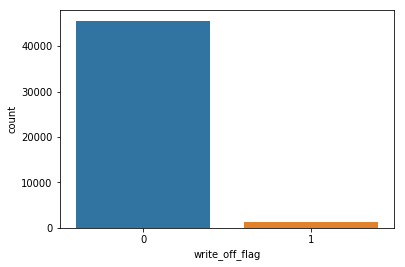

In [300]:
sns.countplot(x='write_off_flag', data=line_of_credit)
plt.show()
plt.savefig('count_plot')

in total, 45,583 did not default and the remaining 1,367 defaulted.

In [301]:
line_of_credit.groupby('write_off_flag').mean()

,total_outstanding_principal,dpd_calendar,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,past_due_interest,current_utilization_pct,lifetime_i_paid,lifetime_p_paid,lifetime_missed_payments,lifetime_partial_payments,lifetime_ot_payments,age_months,lifetime_utilization_pct,lifetime_draw_count,wa_credit_score__c,dpd10slope
write_off_flag,,,,,,,,,,,,,,,,,,
0,8919.12465,4.061251,19694.535243,NaN,NaN,251.264328,27.021393,0.476278,1662.250493,17204.599094,0.976351,0.726718,1.167168,7.0,0.473410,5.321128,684.408089,0.231632
1,394.70605,89.290909,13539.136796,10985.742977,1034.815655,231.785977,36.023819,0.032480,583.587659,3277.171090,15.657644,0.252377,0.376737,7.0,0.607717,2.966350,663.722019,-5.156755


#### In order to gain an understanding of the two groups, the mean of each of the independent variables were calculated.
#### Observations:
The average total_outstanding_principal for loans that defaulted is lower than total_outstanding_principal for loans 
that did not default.
The average credit_limit for loans that defaulted is lower than those that did not default.
The average current_utilization_pct is 20x lower for loan that defaulted compared to loans that did not default.
The average age of loan is is 7months older for those who defailted than those who did not.

In [302]:
line_of_credit.corr()

,total_outstanding_principal,dpd_calendar,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,past_due_interest,current_utilization_pct,lifetime_i_paid,lifetime_p_paid,lifetime_missed_payments,lifetime_partial_payments,lifetime_ot_payments,age_months,lifetime_utilization_pct,lifetime_draw_count,wa_credit_score__c,dpd10slope,write_off_flag
total_outstanding_principal,1.000000,-0.001778,0.557052,0.039629,0.045470,0.139656,0.131024,0.618596,0.752764,0.448185,-0.107479,-0.023020,-0.024373,NaN,0.361769,0.463482,0.074303,0.110804,-0.140058
dpd_calendar,-0.001778,1.000000,-0.072353,0.358439,0.590143,0.644049,0.582931,0.084196,-0.053013,-0.080862,0.867116,0.034463,-0.011462,NaN,0.128741,-0.030049,-0.083525,0.745692,0.160313
credit_limit,0.557052,-0.072353,1.000000,0.928869,0.780346,0.038502,0.008629,-0.071045,0.534218,0.597210,-0.110472,-0.034184,0.013817,NaN,-0.157572,0.077710,0.300716,-0.007753,-0.069712
lsp_wo_new_principal,0.039629,0.358439,0.928869,1.000000,0.870770,0.043310,0.038851,-0.015138,0.524499,0.655031,-0.040424,-0.029551,-0.075833,NaN,0.155058,0.243754,0.290039,-0.010516,NaN
lsp_wo_new_interest,0.045470,0.590143,0.780346,0.870770,1.000000,0.057002,0.071827,-0.001343,0.321473,0.430112,0.171393,-0.097900,-0.142058,NaN,0.201348,0.151437,0.248936,-0.060689,NaN
past_due_principal,0.139656,0.644049,0.038502,0.043310,0.057002,1.000000,0.777441,0.147402,0.087173,-0.021797,0.428766,0.033246,-0.019999,NaN,0.175886,0.038597,-0.059291,0.482702,-0.002258
past_due_interest,0.131024,0.582931,0.008629,0.038851,0.071827,0.777441,1.000000,0.171620,0.028370,-0.031114,0.396144,-0.010087,-0.023679,NaN,0.167204,0.055434,-0.057272,0.491760,0.008686
current_utilization_pct,0.618596,0.084196,-0.071045,-0.015138,-0.001343,0.147402,0.171620,1.000000,0.420515,0.060013,-0.091509,0.003623,-0.037370,NaN,0.669052,0.559409,-0.177783,0.236245,-0.211775
lifetime_i_paid,0.752764,-0.053013,0.534218,0.524499,0.321473,0.087173,0.028370,0.420515,1.000000,0.577805,-0.126666,0.008622,-0.018858,NaN,0.542845,0.500590,0.057242,0.047657,-0.129171
lifetime_p_paid,0.448185,-0.080862,0.597210,0.655031,0.430112,-0.021797,-0.031114,0.060013,0.577805,1.000000,-0.107897,0.069125,0.232708,NaN,0.120092,0.308382,0.170322,0.005967,-0.113985


In [303]:
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(loc.dropna().corr())

### The following variables are highly correlated: 
- write_off_flag and lifetime_missed_payments 
- write_off_flag and dpd_calendar
- write_off_flag and age_months
- total_outstanding_principal and current_utilization_pct 
- total_outstanding_principal and credt_limit 
- wa_credit_score__c and credt_limit 

In [304]:
init_features = ['wa_credit_score__c', 'age_months', 'dpd_calendar', 'lifetime_missed_payments']

## Clean & Explore the Data

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [306]:
# Data cleanup and feature angineering

def feature_engineering(data_frame):
    bit = [0, 1]
    
    data_frame['missed_sub_partial'] = data_frame['lifetime_missed_payments'] - data_frame['lifetime_partial_payments']
    data_frame['current_utilization_pct'].fillna(0, inplace=True)

    data_frame['age_months'] = np.floor(((data_frame['as_of_date'] - data_frame['firstdate'])/np.timedelta64(1, 'D'))/30)
    data_frame['lifetime_missed_payments_norm_age'] = data_frame['lifetime_missed_payments'] / (data_frame['age_months'] + 1)

    data_frame['first_draw_since_close'] = np.maximum((data_frame['first_draw_date'] - data_frame['firstdate'])/np.timedelta64(1, 'D'), 0)   
    data_frame['first_draw_since_close_factor'] = np.where(data_frame['first_draw_since_close'].isin(bit), 1, 0)
    #data_frame['dpd10slope'].fillna(0, inplace=True)
    #data_frame['count'] = np.maximum(data_frame['dpd10slope'], 0)
    #data_frame['count10'] = np.where(data_frame['count'] >= 10, 1, 0)
    
    data_frame['ipratio'] = np.minimum(np.where(data_frame['lifetime_p_paid'] <= 0 | data_frame['lifetime_p_paid'].isnull(), 1,
                                         data_frame['lifetime_i_paid']/data_frame['lifetime_p_paid']), 1)
    data_frame['has_ipratio'] = np.where(data_frame['lifetime_p_paid'] > 0, 1, 0)
    data_frame['wa_credit_score__c'].fillna(678, inplace=True)
    
    data_frame['pastdue_ipratio'] = np.where(data_frame['past_due_principal'] > 0, 
                                   data_frame['past_due_interest']/data_frame['past_due_principal'], 1)
    data_frame['has_pastdue_principal'] = np.where(data_frame['past_due_principal'] > 0, 1, 0)
    
    data_frame['daysSinceLastPay'] = np.floor(((data_frame['as_of_date'] - data_frame['last_cleared_payment_date'])/np.timedelta64(1, 'D'))) 
    data_frame['daysSinceLastPayInt'] = data_frame['daysSinceLastPay']/7
    data_frame['dpd_calendar'].fillna(0, inplace=True)
    
    return(data_frame)

In [307]:
# X_train feature engineering.
X_train = feature_engineering(X_train)
# X_test feature engineering.
X_test = feature_engineering(X_test)

/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [308]:
X_train.join(y_train).corr()

,total_outstanding_principal,dpd_calendar,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,past_due_interest,current_utilization_pct,lifetime_i_paid,lifetime_p_paid,...,lifetime_missed_payments_norm_age,first_draw_since_close,first_draw_since_close_factor,ipratio,has_ipratio,pastdue_ipratio,has_pastdue_principal,daysSinceLastPay,daysSinceLastPayInt,write_off_flag
total_outstanding_principal,1.000000,0.007647,0.554743,0.052555,0.061145,0.141948,0.132951,0.618978,0.754914,0.451757,...,-0.104959,-0.031688,0.019422,0.126717,0.024626,-0.024340,0.029101,-0.303924,-0.303924,-0.139061
dpd_calendar,0.007647,1.000000,-0.068008,0.000043,0.019374,0.658249,0.597368,0.095021,-0.046020,-0.078386,...,0.660607,-0.052941,0.045468,0.157705,-0.009723,-0.662555,0.688971,0.237521,0.237521,-0.001517
credit_limit,0.554743,-0.068008,1.000000,0.921844,0.756308,0.037668,0.007907,-0.072995,0.532370,0.598414,...,-0.108232,0.062358,-0.050643,-0.188621,0.006507,0.086507,-0.088079,0.002801,0.002801,-0.066807
lsp_wo_new_principal,0.052555,0.000043,0.921844,1.000000,0.856637,0.056269,0.052346,-0.002429,0.516686,0.650036,...,-0.032128,0.004973,0.041743,0.043398,-0.082730,0.005490,-0.004250,-0.047603,-0.047603,NaN
lsp_wo_new_interest,0.061145,0.019374,0.756308,0.856637,1.000000,0.074102,0.093111,0.014735,0.305397,0.394190,...,0.169885,0.013256,0.053974,0.056300,-0.152513,-0.004435,0.009587,0.061296,0.061296,NaN
past_due_principal,0.141948,0.658249,0.037668,0.056269,0.074102,1.000000,0.785537,0.150690,0.086337,-0.021668,...,0.435016,-0.043621,0.031349,0.187464,-0.009340,-0.529937,0.547465,0.127001,0.127001,0.001781
past_due_interest,0.132951,0.597368,0.007907,0.052346,0.093111,0.785537,1.000000,0.174038,0.026066,-0.032744,...,0.398940,-0.032188,0.019340,0.111896,-0.011490,-0.446155,0.491081,0.180710,0.180710,0.013259
current_utilization_pct,0.618978,0.095021,-0.072995,-0.002429,0.014735,0.150690,0.174038,1.000000,0.421031,0.062779,...,-0.088795,-0.079870,0.060693,0.357471,0.033947,-0.133978,0.145939,-0.443674,-0.443674,-0.210703
lifetime_i_paid,0.754914,-0.046020,0.532370,0.516686,0.305397,0.086337,0.026066,0.421031,1.000000,0.584996,...,-0.124643,-0.226503,0.130363,0.171203,0.044778,-0.011819,0.007816,-0.310703,-0.310703,-0.127638
lifetime_p_paid,0.451757,-0.078386,0.598414,0.650036,0.394190,-0.021668,-0.032744,0.062779,0.584996,1.000000,...,-0.111080,-0.131794,0.052369,-0.264879,0.037246,0.052045,-0.055377,-0.108625,-0.108625,-0.114131


In [309]:
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(X_train.join(y_train).corr())

In [310]:
features = ['missed_sub_partial','current_utilization_pct','lifetime_missed_payments_norm_age',
            'has_ipratio','has_pastdue_principal', 'wa_credit_score__c', 'first_draw_since_close_factor', 'daysSinceLastPayInt']  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a17d1ca90>,
      dtype=object)

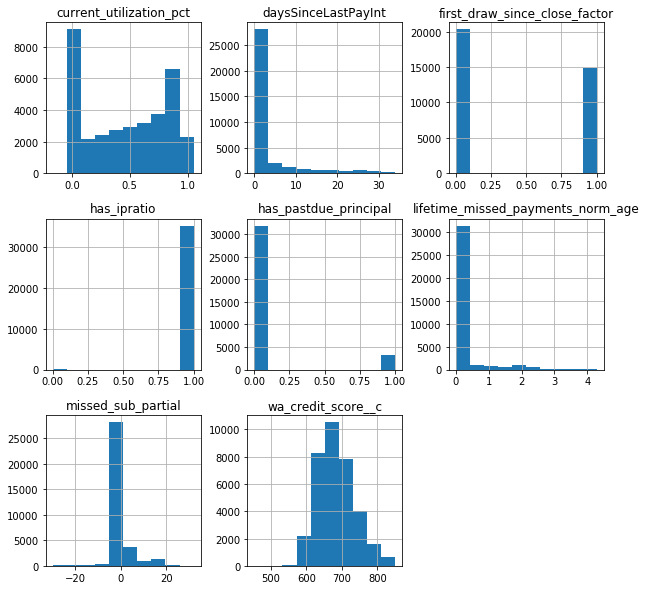

In [311]:
X_train[features].hist(figsize=(10,10))

### Modeling

In [312]:
model_train = smf.Logit(y_train, X_train[features])
result_train = model_train.fit()

Optimization terminated successfully.
         Current function value: 0.022969
         Iterations 11


In [313]:
result_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         write_off_flag   No. Observations:                35212
Model:                          Logit   Df Residuals:                    35204
Method:                           MLE   Df Model:                            7
Date:                Thu, 17 May 2018   Pseudo R-squ.:                  0.8255
Time:                        23:32:45   Log-Likelihood:                -808.77
converged:                       True   LL-Null:                       -4635.0
                                        LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
missed_sub_partial                    0.1566      0.047      3.325      0.001       0.064       0.249
current_utilization_pct               0.5193      0.311      1.668      0.095      -0.091       1.129
lifetime_missed_payments_norm_age     2.1485      0.360      5.962      0.000       1.442       2.855
has_ipratio                          -3.3146      0.344     -9.625      0.000      -3.990      -2.640
has_pastdue_principal                -8.1483      0.359    -22.703      0.000      -8.852      -7.445
wa_credit_score__c                   -0.0062      0.001    -11.106      0.000      -0.007      -0.005
first_draw_since_close_factor         0.7888      0.152      5.191      0.000       0.491       1.087
daysSinceLastPayInt                   0.1210      0.009     13.793      0.000       0.104       0.138
=====================================================================================================
"""

In [314]:
model_test = smf.Logit(y_test, X_test[features])
result_test = model_test.fit()

Optimization terminated successfully.
         Current function value: 0.017061
         Iterations 11


In [315]:
result_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         write_off_flag   No. Observations:                11738
Model:                          Logit   Df Residuals:                    11730
Method:                           MLE   Df Model:                            7
Date:                Thu, 17 May 2018   Pseudo R-squ.:                  0.8705
Time:                        23:32:53   Log-Likelihood:                -200.26
converged:                       True   LL-Null:                       -1546.2
                                        LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
missed_sub_partial                    0.0642      0.062      1.027      0.304      -0.058       0.187
current_utilization_pct               2.0805      0.695      2.996      0.003       0.719       3.442
lifetime_missed_payments_norm_age     3.4717      0.502      6.917      0.000       2.488       4.455
has_ipratio                          -5.2553      0.770     -6.823      0.000      -6.765      -3.746
has_pastdue_principal               -10.7266      0.778    -13.779      0.000     -12.252      -9.201
wa_credit_score__c                   -0.0056      0.001     -4.736      0.000      -0.008      -0.003
first_draw_since_close_factor         1.0297      0.310      3.327      0.001       0.423       1.636
daysSinceLastPayInt                   0.1503      0.019      7.806      0.000       0.113       0.188
=====================================================================================================
"""

In [316]:
clf = LogisticRegression() # param for unbalanced data

In [317]:
clf.fit(X_train[features], y_train)

/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [318]:
clf.score(X_test[features], y_test)

0.9948032032714261

In [319]:
clf.coef_[0][0]

0.21478990648830087

In [320]:
clf.intercept_[0]

0.6570385611330812

In [321]:
predictions = clf.predict(X_test[features])
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11396
          1       0.91      0.91      0.91       342

avg / total       0.99      0.99      0.99     11738



In [322]:
param_grid = param_grid = {
    'C':[0.01, 0.1, 1.0]
}

grid = GridSearchCV(LogisticRegression(), cv=3, param_grid=param_grid)
grid.fit(X_train[features],y_train)

prediction = grid.predict_proba(X_test[features])

/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rcalaquian/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [323]:
grid.best_score_

0.9936953311371124

In [324]:
grid.best_params_

{'C': 1.0}

#### Next Steps
- Let's go!